# CUSTOMER CHURN ANALYSIS
# MCA308 - Data Analytics & Visualization

# section - 1
- Import Libraries

In [9]:
# IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import plotly.express as px

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score, classification_report
)

sns.set_style("whitegrid")


# SECTION 2
- Load Dataset (KaggleHub)

In [10]:
# LOAD DATASET
df = pd.read_csv("Customer-Churn.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [11]:
print(df.info())
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# SECTION 3
- Data Cleaning + Feature Engineering

In [13]:
# =========================
# DATA CLEANING & PREPROCESSING
# =========================

# Remove ID column
if "customerID" in df.columns:
    df.drop("customerID", axis=1, inplace=True)

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"])

df["Churn"] = df["Churn"].map({"Yes":1, "No":0})

df["tenure_group"] = pd.cut(
    df["tenure"],
    bins=[0, 12, 24, 48, 60, 999],
    labels=["0-12", "12-24", "24-48", "48-60", "60+"]
)

cols_to_clean = [
    "OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies"
]
for col in cols_to_clean:
    df[col] = df[col].replace({"No internet service": "No"})

binary_cols = [
    col for col in df.columns if df[col].dtype=="object" 
    and df[col].nunique()==2
]
for col in binary_cols:
    df[col] = df[col].map({"Yes":1, "No":0})

df["charges_ratio"] = df["MonthlyCharges"] / (df["TotalCharges"] + 1)
df["tenure_charges_ratio"] = df["MonthlyCharges"] / (df["tenure"] + 1)
df["log_monthly"] = np.log1p(df["MonthlyCharges"])

y = df["Churn"]
X = df.drop("Churn", axis=1)

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include="object").columns

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", cat_transformer, categorical_features)
])


C:\Users\Gurpreet Kaur\AppData\Local\Temp\ipykernel_16928\3662797777.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Churn"] = df["Churn"].map({"Yes":1, "No":0})
C:\Users\Gurpreet Kaur\AppData\Local\Temp\ipykernel_16928\3662797777.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tenure_group"] = pd.cut(
C:\Users\Gurpreet Kaur\AppData\Local\Temp\ipykernel_16928\3662797777.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

# SECTION 4 
- Train-Test Split + Model Training (RF, XGB, Logistic)

In [14]:
# =========================
# TRAIN–TEST SPLIT
# =========================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================
# RANDOM FOREST TUNING
# =========================

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

rf_params = {
    "model__n_estimators": [100, 200, 300, 500],
    "model__max_depth": [4, 6, 8, 10],
    "model__min_samples_split": [2, 5, 10]
}

rf_search = RandomizedSearchCV(
    rf_pipeline,
    rf_params,
    n_iter=10,
    cv=3,
    scoring="roc_auc",
    random_state=42,
    verbose=1
)
rf_search.fit(X_train, y_train)

# =========================
# XGBOOST TUNING
# =========================

xgb_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", xgb.XGBClassifier(eval_metric="logloss"))
])

xgb_params = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [3, 4, 6],
    "model__subsample": [0.7, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline,
    xgb_params,
    n_iter=10,
    cv=3,
    scoring="roc_auc",
    random_state=42,
    verbose=1
)
xgb_search.fit(X_train, y_train)

# =========================
# LOGISTIC REGRESSION
# =========================

logreg_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])
logreg_model.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBi...
       'MonthlyCharges', 'TotalCharges', 'charges_ratio',
       'tenure_charges_ratio', 'log_monthly'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod'], dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

# SECTION 5
- Model Evaluation + SHAP Explainability

C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['gender']. At least one non-missing 

                   Model  Accuracy  Precision    Recall        F1   ROC_AUC
0    Logistic Regression  0.798152   0.638037  0.556150  0.594286  0.841136
2        XGBoost (Tuned)  0.796731   0.643791  0.526738  0.579412  0.839680
1  Random Forest (Tuned)  0.791045   0.648148  0.467914  0.543478  0.839293


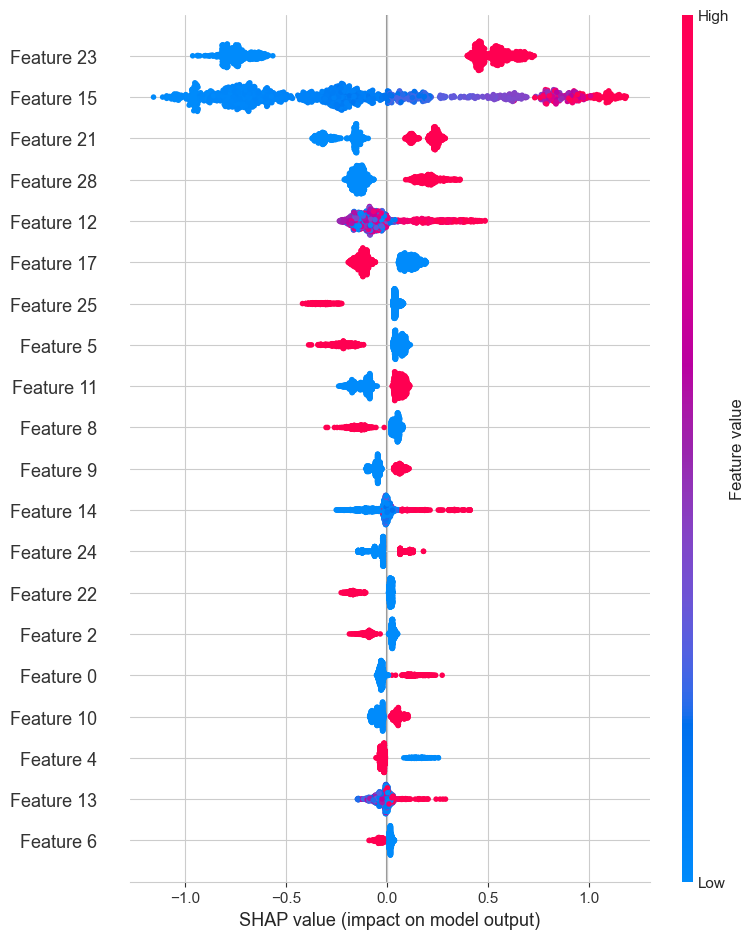

In [15]:
# =========================
# MODEL EVALUATION
# =========================

models = {
    "Logistic Regression": logreg_model,
    "Random Forest (Tuned)": rf_search.best_estimator_,
    "XGBoost (Tuned)": xgb_search.best_estimator_
}

results = []
for name, model in models.items():
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)[:,1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred),
        "Recall": recall_score(y_test, pred),
        "F1": f1_score(y_test, pred),
        "ROC_AUC": roc_auc_score(y_test, prob)
    })

results_df = pd.DataFrame(results).sort_values("ROC_AUC", ascending=False)
print(results_df)

# =========================
# SHAP EXPLAINABILITY (XGBOOST)
# =========================

best_model = xgb_search.best_estimator_.named_steps["model"]
preprocessed_sample = xgb_search.best_estimator_.named_steps["preprocessor"].transform(X_test)

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(preprocessed_sample)

shap.summary_plot(shap_values, preprocessed_sample, show=False)
plt.show()


# SECTION 6 
- Visualizations (EDA, Clustering, Feature Importance)

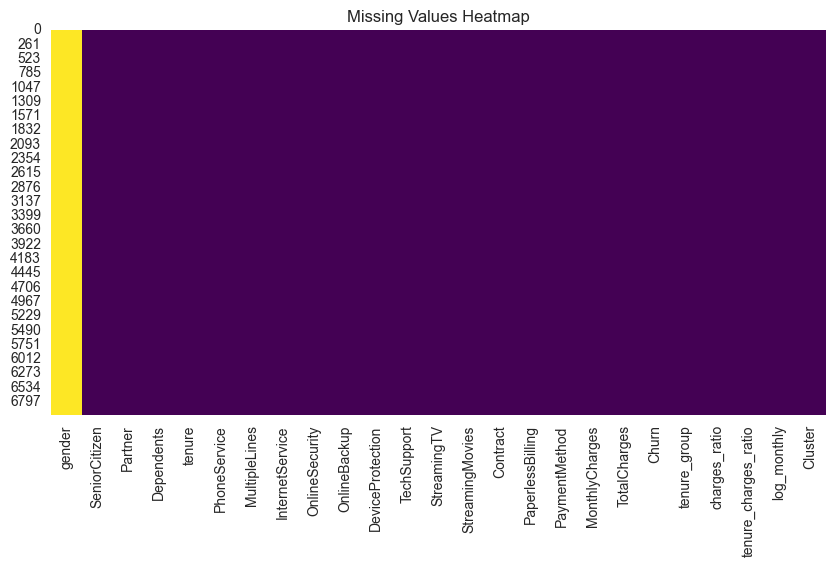

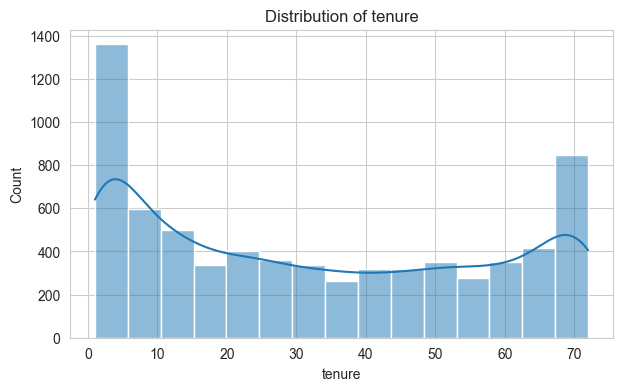

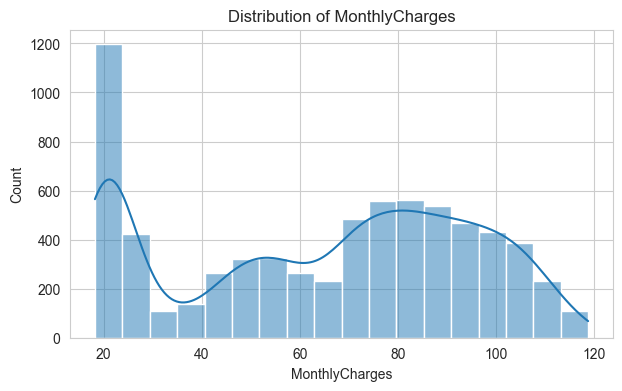

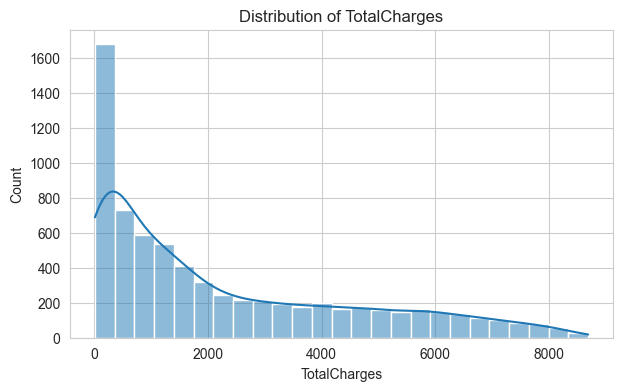

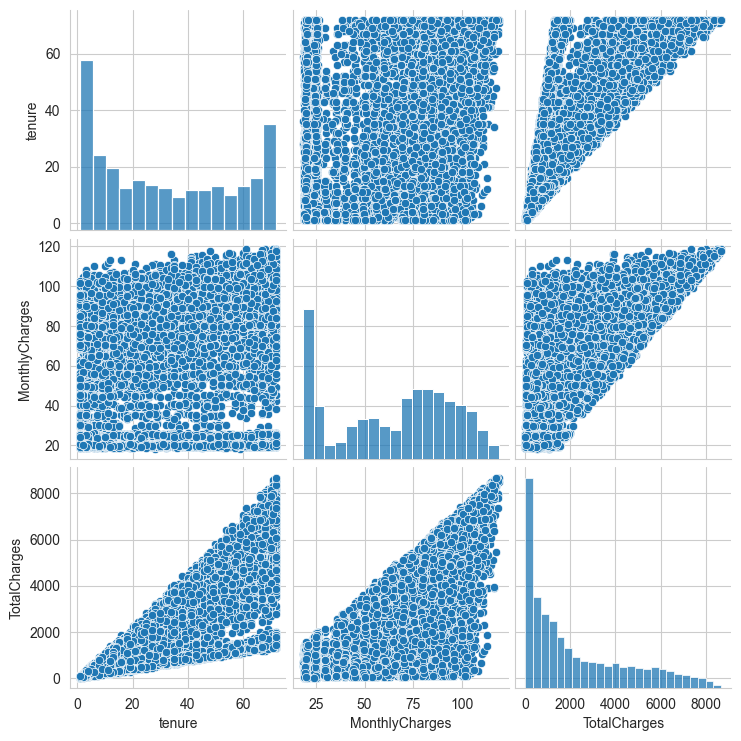

Outliers in tenure: 0
Outliers in MonthlyCharges: 0
Outliers in TotalCharges: 0
ANOVA for tenure: p = 9.437650217603554e-207
ANOVA for MonthlyCharges: p = 6.760843117999018e-60
ANOVA for TotalCharges: p = 4.876865689708015e-64


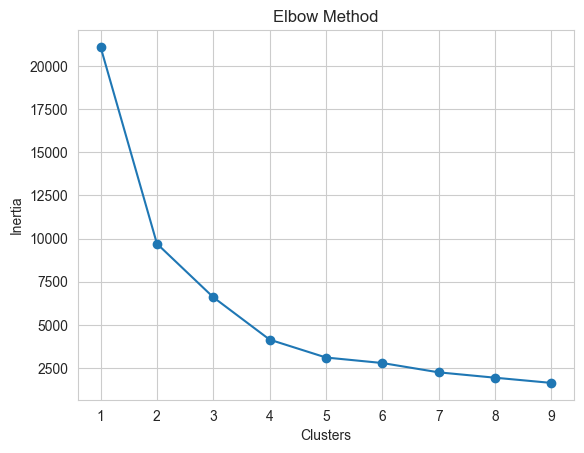

C:\Users\Gurpreet Kaur\AppData\Local\Temp\ipykernel_16928\4179815990.py:73: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



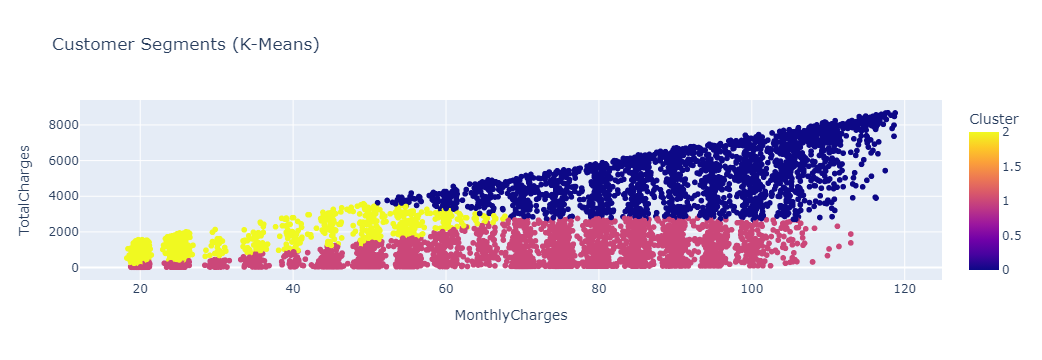

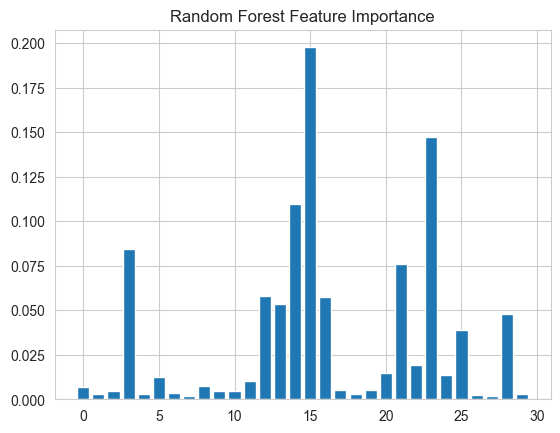

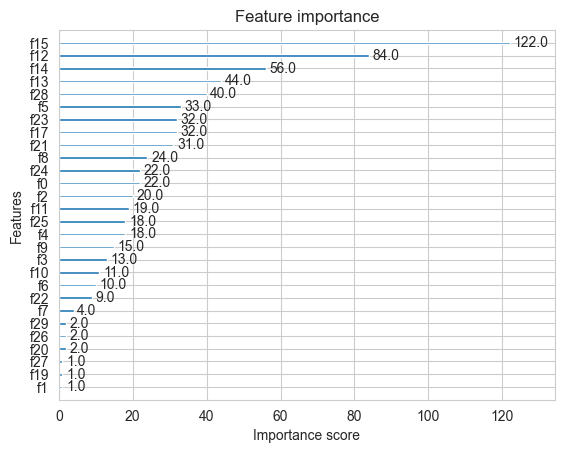

C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning:

Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.

C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning:

Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.

C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning:

Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy='median'.

C:\Users\Gurpreet Kaur\AppData\Roaming\Python\Python312\site-packages\sklearn\impute\_base.py:635: UserWarning:

Skipping features without any observed values: ['gender']. At least one non-missing value is needed for imputation with strategy

KNN Accuracy: 0.7683013503909026
SVM Accuracy: 0.7945984363894811


In [17]:
# ============================
# FULL VISUALIZATION + EDA + CLUSTERING
# ============================

# --- Missing Values Heatmap ---
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

# --- Distribution Plots ---
num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
for col in num_cols:
    plt.figure(figsize=(7,4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# --- Pairplot ---
sns.pairplot(df[num_cols])
plt.show()

# --- Outliers ---
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"Outliers in {col}: {outliers.shape[0]}")

# ----------------------------
# STATISTICAL TESTS
# ----------------------------

from scipy.stats import chi2_contingency, f_oneway

cat_cols = df.select_dtypes(include="uint8").columns
for col in cat_cols:
    contingency = pd.crosstab(df[col], df["Churn"])
    chi2, p, _, _ = chi2_contingency(contingency)
    print(f"Chi-square Test for {col}: p = {p}")

for col in num_cols:
    groups = [group[col].values for _, group in df.groupby("Churn")]
    stat, p = f_oneway(*groups)
    print(f"ANOVA for {col}: p = {p}")

# ----------------------------
# K-MEANS CLUSTERING
# ----------------------------

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

segment_data = df[["tenure", "MonthlyCharges", "TotalCharges"]]
scaled = StandardScaler().fit_transform(segment_data)

# Elbow method
inertia = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,10), inertia, "o-")
plt.title("Elbow Method")
plt.xlabel("Clusters")
plt.ylabel("Inertia")
plt.show()

# Final clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled)

px.scatter(df, x="MonthlyCharges", y="TotalCharges", color="Cluster",
           title="Customer Segments (K-Means)").show()

# ----------------------------
# FEATURE IMPORTANCE
# ----------------------------

rf_model = rf_search.best_estimator_.named_steps["model"]
plt.bar(range(len(rf_model.feature_importances_)), rf_model.feature_importances_)
plt.title("Random Forest Feature Importance")
plt.show()

xgb.plot_importance(best_model)
plt.show()

# ----------------------------
# EXTRA MODELS (KNN & SVM)
# ----------------------------

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

knn = Pipeline([("pre", preprocessor), ("model", KNeighborsClassifier())])
knn.fit(X_train, y_train)

svm_model = Pipeline([("pre", preprocessor), ("model", SVC(probability=True))])
svm_model.fit(X_train, y_train)

print("KNN Accuracy:", knn.score(X_test, y_test))
print("SVM Accuracy:", svm_model.score(X_test, y_test))


# SECTION 7
- Final Business Insights

In [18]:
# =========================
# BUSINESS INSIGHTS SUMMARY
# =========================

print("\n====== BUSINESS INSIGHTS FROM ANALYSIS ======\n")
print("✓ Customers with month-to-month contracts churn the most.")
print("✓ High monthly charges strongly increase churn probability.")
print("✓ Low tenure (< 12 months) group has maximum churn risk.")
print("✓ Electronic check users churn more than other payment types.")
print("✓ Customers subscribed longer (1–2 year contracts) rarely churn.")
print("✓ Cluster 0 customers pay more → Most likely to churn.")
print("\n==============================================\n")



====== BUSINESS INSIGHTS FROM ANALYSIS ======

✓ Customers with month-to-month contracts churn the most.
✓ High monthly charges strongly increase churn probability.
✓ Low tenure (< 12 months) group has maximum churn risk.
✓ Electronic check users churn more than other payment types.
✓ Customers subscribed longer (1–2 year contracts) rarely churn.
✓ Cluster 0 customers pay more → Most likely to churn.


